# Introduction

The purpose of this notebook is to construct a model that accurately predicts the sentiment of Pitchfork music reviews based on the content of the review. To start, the scope of the problem will be restricted to polarized reviews, i.e. either they loved the album or they hated it.

If you're not familiar with Pitchfork (https://pitchfork.com/), it's a website that reviews new albums and reports on other music related things. It tilts more towards a hipster/indie crowd, and they select the albums that they review (leading to a higher average score than one might expect). Album reviews are given a score from $0$ to $10$ (decimal increments of $.1$). Albums that achieve a score of $8+$ can be filtered (https://pitchfork.com/best/high-scoring-albums/), so in this notebook a positive review is defined as any review with an $8+$ review.

What determines a negative review is debatable. This will be covered when the data is examined (slightly) more closely.

In [1]:
#Data handling
import numpy as np
import pandas as pd

#Graphing
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns

#General
import pickle
import time
import datetime
from collections import Counter

#Words
import nltk
import re
import textblob

#Model prep
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.pipeline import Pipeline

#Learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#Metrics
from sklearn.metrics import plot_roc_curve

In [2]:
#Load Data
with open('Pitchfork_df.pickle', 'rb') as f:
    df = pickle.load(f)

# Data Cleaning

In [3]:
#Take out if there is a featured track and add it as a separate feature
df['featured_track'] = df.review.apply(lambda x: len(re.findall(r'Featured Tracks\:Play Track', x)))
df['review'] = df.review.apply(lambda x: re.sub(r'Featured Tracks\:Play Track', '', x))

#Check whether there is a buy offer
df['buy_offer'] = df.review.apply(lambda x: len(re.findall(r'Buy\:.*', x)))
df['review'] = df.review.apply(lambda x: re.sub(r'Buy\:.*\n.*', '', x))

#Get rid of closing lines
df['review'] = df.review.apply(lambda x: re.sub(r'Back to home', '', x))
df['review'] = df.review.apply(lambda x: re.sub(r'Catch up every Saturday.*', '', x))
df['review'] = df.review.apply(lambda x: re.sub(r'Get the Sunday Review.*','', x))

#Record if the review is a rave and length of review
df['rave'] = df.score.apply(lambda x: int(x >= 8))
df['review_count'] = df.review.apply(lambda x: len(x.split()))

In [4]:
#Function to clean up review feature in one sweep
def pos_transform(review):
    
    """This strips punctuation, changes contractions, removes certain words, removes most parts of speech besides nouns, verbs, adjectives, and adverbs, 
    lemmatizes all words according to their part of speech, and gets rid of all short words (len < 3)"""
    
    #Strip punctuation
    review = re.sub(r'\W', ' ', review)
    
    #Contractions to split (and other words needing replacement)
    replace_dict = {"couldn": 'could not', "Couldn": 'could not', "shouldn": 'should not', 
                "Shouldn": 'should not', "isn": 'is not', "Isn": 'is not', "didn": 'did not', 
                "Didn": 'did not', "won t": 'will not', "Won t": 'will not', "wouldn": 'would not', 
                "Wouldn": 'would not', "Wasn": 'was not', "wasn": 'was not', "weren": 'were not',
                "Weren": 'were not', "can t": 'cannot', "can not": 'cannot', "Can t": 'cannot', 
                "Aren": 'are not', "aren": 'are not', "don t": 'do not', "Don t": 'do not', 
                "doesn": 'does not', "Doesn": 'does not', "haven t ": 'have not', "Haven t": 'have not', 
                "Hasn": 'has not', "hasn": 'has not', "Hadn": 'had not', "hadn": 'had not', 
                   'no': 'not', 'No': 'not', 
                   'from': '', 'with': '', 'later': '',
                   'Ain': 'are not', 'ain': 'are not', 'dox92t': ''} 
    
    #Replace words
    pattern = re.compile(r'\b(' + '|'.join(replace_dict.keys()) + r')\b')
    review = pattern.sub(lambda x: replace_dict[x.group()], review)

    
    #List of of POS to discard
    speech = ['CC', 'CD', 'DT', 'EX', 'FW', 'LS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RP', 'SYM', 
             'TO', 'WB$', 'IN', 'MD', 'WDT', 'WP']
    
    #Tokenize text and label with POS
    tokens = nltk.tokenize.word_tokenize(review)
    tokens = nltk.pos_tag(tokens)
    
    #Get rid of unwanted POS, but keep labels for now
    tokens = [toke for toke in tokens if toke[1] not in speech]
    
    #Change the POS tag so that lemmatization can be used effectively
    pos_tag_dict = {'NN': 'n', 'NNS': 'n', 'JJ': 'a', 'JJR': 'a', 'JJS': 'a', 'RB': 'r', 'RBR': 'r', 'RBS': 'r', 
                   'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBP': 'v', 'VBZ': 'v', 'VBN': 'v'}
    tokens = [(toke[0], pos_tag_dict.get(toke[1], 'n')) for toke in tokens]
    
    #Lemmatize tokens
    lm = nltk.stem.WordNetLemmatizer()
    tokens = [lm.lemmatize(toke[0], pos = toke[1]) for toke in tokens]
    
    #Get rid of short words and repetition
    tokens = [toke for toke in tokens if len(toke)>2]

    #Join text back together and return
    review = ' '.join(tokens)
    
    
    return review

In [5]:
#Clean up review
df['review'] = df.review.apply(pos_transform)

# Brief Data Exploration

The main purpose here is to quickly examine the data and see if there is a natural way to define the point cut-off for a negative review. Looking at simple statistics about the scores, the third quartile is $7.8$, which is slightly lower than the previously decided $8$ cut-off. It makes the most sense to define a negative review to be slightly below the first quartile of $6.5$

In [6]:
df.score.describe()

count    22794.000000
mean         7.060906
std          1.242532
min          0.000000
25%          6.500000
50%          7.300000
75%          7.800000
max         10.000000
Name: score, dtype: float64

In [7]:
#Create a binary donut chart
def binary_donut(cut_off):
    temp_df = df[(df.score >= 8) | (df.score <= cut_off)]
    
    pre_pie = Counter(temp_df.rave)
    pre_pie = {'rave': pre_pie[1], 'rant': pre_pie[0]}
    
    #Create pie chart
    plt.pie(x = pre_pie.values(),
            labels = pre_pie.keys(),
            colors = ['#ff9999', '#66b3ff'],
            autopct = '%1.1f%%',
            pctdistance = .85,
            startangle = 90);
    
    #Make the pie a donut by covering up part
    circle = plt.Circle((0,0), .7, fc = 'white')
    fig = plt.gcf()
    
    fig.gca().add_artist(circle)
    plt.axis('equal')
    plt.tight_layout()

Defining a negative review as one with a score of $6.2$ or fewer results in a similar number of negative reviews as compared to positive reviews (as seen below).

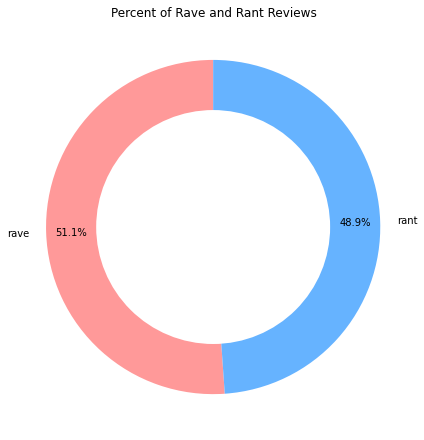

In [8]:
#Plot donut graph
plt.figure(figsize = (6,6))
binary_donut(6.2)
plt.title('Percent of Rave and Rant Reviews');

In [9]:
#Create a new DataFrame of polarized reviews
model_df = df[(df.score >= 8) | (df.score <= 6.2)].copy()

# Rave/Rant Prediction Training

In [10]:
#Split data into train and test set
X = model_df.review
y = model_df.rave
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0)

#Save the testing indices for later
y_test_indices = y_test.index

#Change to arrays
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

#Get the 5-fold cross validation ready
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

## Logistic Regression Model

In [11]:
#Pipeline Layer 1 - Vectorizer
vect = TfidfVectorizer(strip_accents = 'unicode',
                      ngram_range = (1,3), 
                      min_df = 3)

#Pipeline Layer 2 - Feature Selection
sel = SelectKBest(score_func = f_classif,
                 k = 'all')

#Pipeline Layer 3 - Model
log_model = LogisticRegression(C = 300, 
                           solver = 'saga', 
                           random_state = 0,
                              max_iter = 1000)

#Logistic Regression Pipeline
log_pipe = Pipeline([('vector', vect), 
                ('select', sel), 
                ('log', log_model)])

In [12]:
st = time.time()
log_scores = []

#K Fold Testing
for train_index, val_index in skf.split(X_train, y_train):
    
    #Split data
    X_train_split, X_val = X_train[train_index], X_train[val_index]
    y_train_split, y_val = y_train[train_index], y_train[val_index]
    
    #Apply pipeline
    log_pipe.fit(X_train_split, y_train_split)
    
    #Track accuracy on validation
    log_scores.append(log_pipe.score(X_val, y_val))
    
print(log_scores)
print(np.mean(log_scores))
print(time.time() - st)

[0.8852126941255908, 0.8798109385550303, 0.8757596218771101, 0.8919648885887913, 0.887238352464551]
0.8839972991222147
158.3538842201233


In [13]:
log_pipe.fit(X_train, y_train)

Pipeline(steps=[('vector',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3),
                                 strip_accents='unicode')),
                ('select', SelectKBest(k='all')),
                ('log',
                 LogisticRegression(C=300, max_iter=1000, random_state=0,
                                    solver='saga'))])

## SVM Model

In [14]:
#Pipeline Layer 1 - Vectorizer
vect = TfidfVectorizer(strip_accents = 'unicode',
                      ngram_range = (1,3), 
                      min_df = 3)

#Pipeline Layer 2 - Feature Selection
sel = SelectKBest(score_func = f_classif,
                 k = 'all')

#Pipeline Layer 3 - Model
svm_model = SVC(kernel = 'linear', 
               C = 3, 
               degree = 2,
               gamma = 'scale')

#SVM Pipeline
svm_pipe = Pipeline([('vector', vect), 
                ('select', sel), 
                ('svm', svm_model)])

In [15]:
st = time.time()
svm_scores = []

#K Fold Testing
for train_index, val_index in skf.split(X_train, y_train):
    
    #Split data
    X_train_split, X_val = X_train[train_index], X_train[val_index]
    y_train_split, y_val = y_train[train_index], y_train[val_index]
    
    #Apply pipeline
    svm_pipe.fit(X_train_split, y_train_split)
    
    #Track accuracy on validation
    svm_scores.append(svm_pipe.score(X_val, y_val))
    
print(svm_scores)
print(np.mean(svm_scores))
print(time.time() - st)

[0.8825118163403106, 0.8811613774476705, 0.8784604996623903, 0.8926401080351114, 0.8818365968939905]
0.8833220796758947
822.0414135456085


In [16]:
svm_pipe.fit(X_train, y_train)

Pipeline(steps=[('vector',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3),
                                 strip_accents='unicode')),
                ('select', SelectKBest(k='all')),
                ('svm', SVC(C=3, degree=2, kernel='linear'))])

# Rave/Rant Prediction

## Models

In [17]:
log_pred = log_pipe.predict(X_test)

print('Accruacy for the logistic regression model is {}'.format(log_pipe.score(X_test, y_test)))
print('')
print(confusion_matrix(y_test, log_pred))
print('')
print(classification_report(y_test, log_pred))

Accruacy for the logistic regression model is 0.8936285097192225

[[783 108]
 [ 89 872]]

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       891
           1       0.89      0.91      0.90       961

    accuracy                           0.89      1852
   macro avg       0.89      0.89      0.89      1852
weighted avg       0.89      0.89      0.89      1852



In [18]:
svm_pred = svm_pipe.predict(X_test)

print('Accruacy for the SVM model is {}'.format(svm_pipe.score(X_test, y_test)))
print('')
print(confusion_matrix(y_test, svm_pred))
print('')
print(classification_report(y_test, svm_pred))

Accruacy for the SVM model is 0.892548596112311

[[779 112]
 [ 87 874]]

              precision    recall  f1-score   support

           0       0.90      0.87      0.89       891
           1       0.89      0.91      0.90       961

    accuracy                           0.89      1852
   macro avg       0.89      0.89      0.89      1852
weighted avg       0.89      0.89      0.89      1852



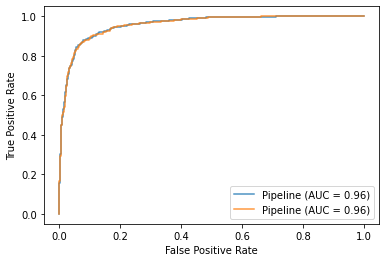

In [19]:
log_roc = plot_roc_curve(log_pipe, X_test, y_test, alpha = .8)

ax = plt.gca()
svm_roc = plot_roc_curve(svm_pipe, X_test, y_test, ax=ax, alpha = .8)

Clearly the SVM model and the logistic regression model both perform well, with neither substantially better than the other. However, logistic regression is much faster to train and test. It's also easier to determine which words and phrases are being given the greatest weight with the logistic regression model.

For these reasons, it makes sense to use the logistic regression model as the primary model.

## Best Words

Since the logistic regression model was superior, it's very easy to determine how it weights specific words and phrases. In this section, the preprocessing steps of the pipeline will be used to determine which words and phrases have the largest effect on the model

In [20]:
#Vectorizer
vect = TfidfVectorizer(strip_accents = 'unicode',
                      ngram_range = (1,3), 
                      min_df = 3)

#Model
log_model = LogisticRegression(C = 300, 
                           solver = 'saga', 
                           random_state = 0,
                              max_iter = 1000)

In [21]:
#Vectorize training and test data
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

#Train model
log_model.fit(X_train_vect, y_train)

LogisticRegression(C=300, max_iter=1000, random_state=0, solver='saga')

In [22]:
#Create a dictionary converting indices to a word or phrase
vect_dict = {num:word for (word, num) in vect.vocabulary_.items()}

#Create a list with words/phrases and model coefficients
word_list = [(log_model.coef_[0][ind], vect_dict[ind]) for ind in vect_dict.keys()]

In [23]:
#List the top twenty words for a rave review
print('Best words for a rave review: \n')
word_list.sort(reverse = True)
for num, word in word_list[:20]:
    print('{0} --- {1}'.format(word, num))
print('')

#List the top twenty words for a rant review
print('Best words for a rant review: \n')
word_list.sort()
for num, word in word_list[:20]:
    print('{0} --- {1}'.format(word, num))

Best words for a rave review: 

reissue --- 14.004223636763342
music --- 12.840987387434724
also --- 11.860858283185213
most --- 11.40062933404666
record --- 9.566376332000683
perfect --- 9.521379256500165
love --- 9.36694027822453
classic --- 9.25935721152005
beautiful --- 9.099116247817584
jazz --- 8.965103468640788
kick --- 8.811117041163628
gorgeous --- 8.767297364815756
note --- 8.631684136006886
ever --- 8.575628125457893
strange --- 8.49817583135031
accessible --- 8.369251970532263
deep --- 8.320404108779943
street --- 8.289006399147915
full --- 7.986790499692443
first --- 7.722891990188054

Best words for a rant review: 

unfortunately --- -20.477517598369065
bad --- -19.248173845638384
problem --- -18.02432545989805
attempt --- -17.183065251187237
lack --- -16.276754687561407
least --- -16.253216608869142
interesting --- -11.832106434174012
fail --- -11.292674724349204
little --- -10.9965642295181
try --- -10.311923575573841
bland --- -10.171672112916092
dull --- -9.9146411595

This is exciting to see! While there are some features that don't make sense ('also', 'too', 'music'), most of the features included would also be words that a human might naturally identify as important. Words like 'love' and 'beautiful' and 'perfect' would clearly indicate a positive review, while 'bad' and 'fail' and 'bland' are clearly negative.

The model has even identified words that would normally be considered good, but in this context are not. Since Pitchfork values original and creative music, then the very bland descriptors of 'interesting', 'nice', and 'pleasant' appear to be more commonly associated with bad reviews. Another feature worth pointing out is 'reissue'. While this is normally a neutral word, since only great albums normally get reissued, then this becomes a very positive word.

## Errors

In [24]:
test_df = model_df.loc[y_test_indices]
probs = log_model.predict_proba(X_test_vect)

test_df['log_guess'] = log_pred
test_df['rant_prob'] = probs[:,0]
test_df['rave_prob'] = probs[:,1]
test_df['prob_dif'] = test_df.apply(lambda x: abs(x.rant_prob - x.rave_prob), axis = 1)

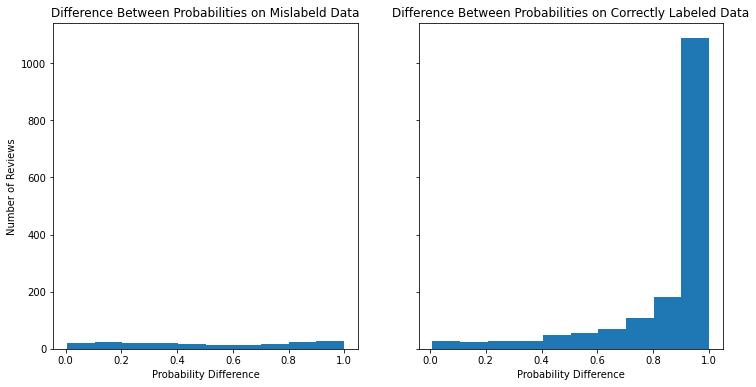

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6), sharey = True)

ax1.hist(test_df[test_df.log_guess != test_df.rave].prob_dif);
ax1.set_xlabel('Probability Difference')
ax1.set_ylabel('Number of Reviews')
ax1.set_title('Difference Between Probabilities on Mislabeld Data');
ax2.hist(test_df[test_df.log_guess == test_df.rave].prob_dif);
ax2.set_xlabel('Probability Difference')
ax2.set_title('Difference Between Probabilities on Correctly Labeled Data');

The model appears to be very confident on the correctly labeled data. On the mislabeled data, the difference between the probabilities is fairly uniform. It's highly unlikely that changing the boundary for positive/negative in the model would have any positive effect on the accuracy. Most likely this model is a fairly optimal logistic regression model given the data. Improvements could possibly occur through more preprocessing of the data or using an alternative model, such as a CNN, which has been shown to be highly effective at sentiment analysis at the sentence level (although much, much, much slower). 

I want to point out that Naive Bayes is okay for this data, but nowhere near how logisitic regression performed.

## Neutral Data

In [26]:
#Create DataFrame of neutral data that was excluded
neutral_df = df[(df.score > 6.2) & (df.score < 8)].copy()

#Get reviews and score
X_neu = neutral_df.review
y_neu = neutral_df.score

#Vectorize X
X_neu_vect = vect.transform(X_neu)
neu_guess = log_model.predict(X_neu_vect)

neu_count = Counter(neu_guess)
neutral_df['pred'] = neu_guess

print('Of the {0} neutral reviews, the logistic regression model classified \n {1} as negative \n {2} as positive'.format(neutral_df.shape[0], neu_count[0], neu_count[1]))

Of the 13537 neutral reviews, the logistic regression model classified 
 5292 as negative 
 8245 as positive


In [27]:
#Create a DataFrame with percentage of scores
pre_df = []
for group, member in neutral_df.groupby('score'):
    td_0 = dict()
    td_1 = dict()
    
    td_0['score'] = group
    td_0['category'] = 0
    td_0['pct'] = member[member.pred == 0].shape[0] / member.shape[0] * 100
    
    td_1['score'] = group
    td_1['category'] = 1
    td_1['pct'] = member[member.pred == 1].shape[0] / member.shape[0] * 100
    
    
    
    pre_df.append(td_0)
    pre_df.append(td_1)
    
plot_df = pd.DataFrame(pre_df)

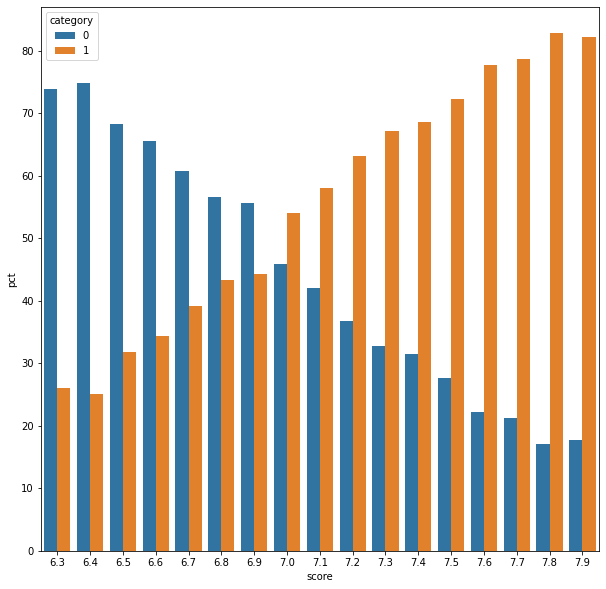

In [28]:
plt.figure(figsize = (10,10))
sns.barplot(x = 'score', y = 'pct', hue = 'category', data = plot_df);

The overall trend makes sense, with a higher percentage of scores near $8$ being classified as positive and more scores near $6.2$ being classified as negative. It's interesting that over $25\%$ of the $6.3$ reviews are still classified as positive; this lines up with the fact that our model had higher recall on the positive class, but lower precision.

A continuation of this project would be to figure out how to include neutral classes without the accuracy plummeting.